# Post processing and visualizing mandyoc data:
## Comparing evolution of temperature diference in the asthenospheric mantle for cratonic and non cratonic regions

In [29]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import sys
import glob
import pymp
import numpy as np
import pylab as pl
import xarray as xr
import pandas as pd
import mpl_toolkits.axisartist
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

In [30]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean


def calc_temper_profiles(data, Lx, Nz, xx, Lcraton=1200, onlycraton=False, shift=0.0):
    xcenter = (Lx/2)/1.0e3 + shift/1.0e3

    # keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/2, xcenter - Lcraton/6)
    # keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/12, xcenter + Lcraton/12)
    # keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/6, xcenter + Lcraton/2)

    keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 350, xcenter - 250)
    keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 50, xcenter + 50)
    keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 250, xcenter + 350)

    out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - Lcraton/2 - 200)
    out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/2 + 200, Lx/1.03 - 200)

    if(onlycraton):
        temper_profiles = [keel_mean_l, keel_mean_c, keel_mean_r]
    else:
        temper_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]

    return temper_profiles

def make_subplotA(ax, x, Lx, model_features, thickness_sa = 40 * 1.0e3, thickness_upper_crust = 20 * 1.0e3, thickness_lower_crust = 15 * 1.0e3, thickness_litho = 80 * 1.0e3):

    if(('mbdo' in model_features) or ('mbwo' in model_features)):
        mobile_belt = True
    else:
        mobile_belt = False

    if('sc' in model_features):
        shift_craton = 700.0e3
    else:
        shift_craton = 0.0e3

    if('lc' in model_features):
        Lcraton = 2000.0e3 #m
    else:
        Lcraton = 1200.0e3

    if('shallow30' in model_features):
        thinning = 135.0e3
    else:
        thinning = 100.0e3

    print(f"Mobile Belt: {mobile_belt}")
    print(f"Shift craton: {shift_craton}")
    print(f"Length of craton: {Lcraton/1.0e3} km")

    #Building the interfaces
    if(mobile_belt == False):
            interfaces = {
                    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa),
                    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
                    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
                    "air": np.ones(Nx) * (thickness_sa),
                    }

            dx = Lx/(Nx-1)
            thickening = thickness_litho + 120.e3 #m
            Ncraton = int(Lcraton//dx) #largura em indices
            
            Nshift = int(shift_craton//dx)
            interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

    else: #with mobile belt
        interfaces = {
            "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
            "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
            "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
            "air": np.ones(Nx) * (thickness_sa),
            }

        #Building craton
        dx = Lx/(Nx-1)
        # Lcraton = 600.0e3 #m
        # Lcraton = 1200.0e3 #m
    #     Lcraton = 2000.0e3 #m
        thickening = thickness_litho + 120.e3 #m

        Ncraton = int(Lcraton//dx) #largura em indices

        Nshift = int(shift_craton//dx)

        interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        
        #Building mobile belt
        interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        Lmb = 300.0e3 #length of mobile belt
        N_Lmb = int(Lmb//dx)
        # thinning = 50.0e3
        # thinning = 100.0e3
        # thickening = 135.0e3

        interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

    alpha = 1
    color='xkcd:black'
    if(mobile_belt):
        ax.plot(x, interfaces['litho_LAB']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['litho_HETERO']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['lower_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='lower crust interface')
        ax.plot(x, interfaces['upper_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='upper crust interface')
        ax.plot(x, interfaces['air']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='air interface')
    else:
        ax.plot(x, interfaces['litho_LAB']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['lower_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='lower crust interface')
        ax.plot(x, interfaces['upper_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='upper crust interface')
        ax.plot(x, interfaces['air']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='air interface')

    #layers colour scheme
    cr = 255.
    color_uc = (228./cr,156./cr,124./cr)
    color_lc = (240./cr,209./cr,188./cr)
    color_lit = (155./cr,194./cr,155./cr)
    color_mb = 'xkcd:dull green'
    # color_mb = color_lit
    color_ast = (207./cr,226./cr,205./cr)

    #paint layers
    # mobile_belt=False
    if(mobile_belt):
        #paint layers
        a1_stab = interfaces["litho_LAB"] - 40.0e3
        a2_stab = a1_stab*0 + 700.0E3 - 40.0e3
        
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["litho_HETERO"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_mb,ec="face",lw=0.0, alpha=0.6)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["lower_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["upper_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab= interfaces["air"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

    else:
        a1_stab = interfaces["litho_LAB"]-40.0e3
        a2_stab = a1_stab*0+700.0E3-40.0e3

        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["lower_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["upper_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab= interfaces["air"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

    xcenter = (Lx/2)/1.0e3
    condl = (x >= (xcenter - 350)) & (x <= (xcenter - 250))
    condc = (x >= (xcenter - 50)) & (x <= (xcenter + 50))
    condr = (x >= (xcenter + 250)) & (x <= (xcenter + 350))

    cond_outl = (x >= 200) & (x <= (xcenter - Lcraton/2.0e3 - 200))
    cond_outr = (x >= (xcenter + Lcraton/2.e3 + 200)) & (x <= (Lx/1.0e3 - 200))

    # color='black'
    # color='grey'
    color='xkcd:purple'
    # color='xkcd:light grey'
    ax.fill_between(x[cond_outl], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condl], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condc], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condr], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[cond_outr], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    
    ax.set_xlim([xcenter-Lcraton/2.0e3-50, xcenter+Lcraton/2.0e3+50])
    ax.set_ylim([660, -40])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_label_position('top')

    ax.set_xlabel('Distance [km]')
    ax.set_ylabel('Depth [km]')

def calc_mean_region(data, xx, zz, xbegin, xend, zbegin, zend):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nx: int
        Number of points in X direction

    xx: numpy.ndarray
        2D grid with x cordinates

    zz: numpy.ndarray
        2D grid with z cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    mean: float
         Mean of selected region
    '''

    region  = (xx >= xbegin) & (xx <= xend) & (zz >= zbegin) & (zz <= zend)

    xregion = (xx >= xbegin) & (xx <= xend)
    zregion = (zz >= zbegin) & (zz <= zend)

    Nx_new = len(xregion[0][xregion[0] == True])
    Nz_new = len(zregion.T[0][zregion.T[0] == True])

    data_region = np.asarray(data)[region].reshape(Nz_new, Nx_new)
    mean = np.round(np.mean(data_region), 2)

    return mean

def calc_mean_evolutions(data, xx, zz, Lx, Lz, xcenter, Lcraton, mobile_belt=False):
    #Cratonic region
    if(mobile_belt):
        xcbegin = xcenter - 150
        xcend = xcenter + 150
        zcbegin = 300.0
        zcend = Lz/1.0e3
    else:
        xcbegin = xcenter - Lcraton/2.0e3 + 50
        xcend = xcenter + Lcraton/2.0e3 - 50
        zcbegin = 300.0
        zcend = Lz/1.0e3

    #Out of cratonic region - left side
    xlbegin = 200
    xlend = xcenter - Lcraton/2.0e3 - 200
    zlbegin = 300.0
    zlend = Lz/1.0e3

    #Out of cratonic region - right side
    xrbegin = xcenter + Lcraton/2.0e3 + 200
    xrend = Lx/1.0e3 - 200
    zrbegin = 300.0
    zrend = Lz/1.0e3

    t0 = data.time[0]
    start = int(t0)
    end = int(data.time.size - 1)
    step = 1

    temper_diff_dict = pymp.shared.dict()
    temper_craton_dict = pymp.shared.dict()
    temper_out_dict = pymp.shared.dict()

    with pymp.Parallel() as p:
        for index in p.range(start, end+step, step):
            datai = data.temperature[index].values.T

            meanc = calc_mean_region(datai, xx, zz, xcbegin, xcend, zcbegin, zcend)
            meanl = calc_mean_region(datai, xx, zz, xlbegin, xlend, zlbegin, zlend)
            meanr = calc_mean_region(datai, xx, zz, xrbegin, xrend, zrbegin, zrend)
            mean_out = np.mean([meanl, meanr])

            temper_craton_dict[index] = meanc
            temper_out_dict[index] = mean_out

            temper_diff = meanc - mean_out
            temper_diff_dict[index] = temper_diff

    ####################################################################################################################

    #Sorting the dictionaries 
    temper_diff_dict = dict(temper_diff_dict)
    temper_craton_dict = dict(temper_craton_dict)
    temper_out_dict = dict(temper_out_dict)

    temper_diff_evol = np.asarray([])
    temper_craton_evol = np.asarray([])
    temper_out_evol = np.asarray([])

    for element in sorted(temper_diff_dict):
        # print(element, temper_diff_dict[element])
        temper_diff_evol = np.append(temper_diff_evol, temper_diff_dict[element])
        temper_craton_evol = np.append(temper_craton_evol, temper_craton_dict[element])
        temper_out_evol = np.append(temper_out_evol, temper_out_dict[element])

    return temper_diff_evol, temper_craton_evol, temper_out_evol

In [31]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"


comp_mb = False
# comp_mb = True 

if(comp_mb):
    scenarios = [
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1",
             ]
else:
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf",
                ]



print(f"Scernarios:")
for scenario in scenarios:
    print(f"{scenario.split('/')[-1]}")

#Read datasets
    
# dataset0 = xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc')
# dataset1 = xr.open_dataset(f'{scenarios[1]}/_output_temperature.nc')
# dataset2 = xr.open_dataset(f'{scenarios[2]}/_output_temperature.nc')
# dataset3 = xr.open_dataset(f'{scenarios[3]}/_output_temperature.nc')

if(len(scenarios) == 3):
    datasets = [
                xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc'),
                xr.open_dataset(f'{scenarios[1]}/_output_temperature.nc'),
                xr.open_dataset(f'{scenarios[2]}/_output_temperature.nc'),
                ]
elif(len(scenarios) == 4):
    datasets = [
                xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc'),
                xr.open_dataset(f'{scenarios[1]}/_output_temperature.nc'),
                xr.open_dataset(f'{scenarios[2]}/_output_temperature.nc'),
                xr.open_dataset(f'{scenarios[3]}/_output_temperature.nc'),
                ]

Nx = int(datasets[0].nx)
Nz = int(datasets[0].nz)
Lx = float(datasets[0].lx)
Lz = float(datasets[0].lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{datasets[0].info}")

Scernarios:
keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf
keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc
keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf

<bound method Dataset.info of <xarray.Dataset> Size: 91MB
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 3kB 0.0 2.5 5.0 7.5 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 2kB ...
  * x            (x) float64 3kB 0.0 1e+04 2e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 568B -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 91MB ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:    

keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf
Mobile Belt: False
Shift craton: 0.0 km
Length of craton: 1200.0 km

keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc
Mobile Belt: False
Shift craton: 700.0 km
Length of craton: 1200.0 km

keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf
Mobile Belt: False
Shift craton: 0.0 km
Length of craton: 1200.0 km

Saving figure: Ast_temper_evolution_ref_vs_sc_aw


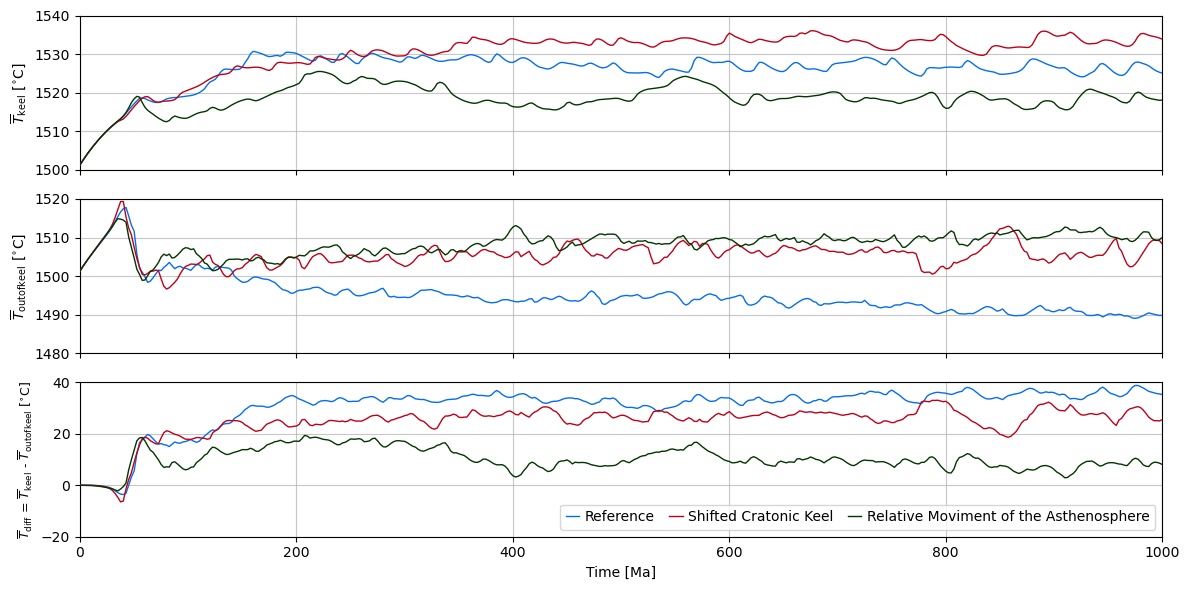

In [32]:
plt.close('all')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['xkcd:cerulean blue', 'xkcd:scarlet', 'xkcd:dark green', 'xkcd:light orange', 'xkcd:lighter purple'])

fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 6), sharex=True, tight_layout=True)

if(len(scenarios) == 3):
    labels = ['Reference', 'Shifted Cratonic Keel', 'Relative Moviment of the Asthenosphere']

elif(len(scenarios) == 4):
    labels = ['Reference', 'Wet Olivine x 5', 'Wet Olivine x 3', 'Wet Olivine x 1']


for scenario, dataset, label in zip(scenarios, datasets, labels):
    
    model_features = scenario.split('/')[-1].split('_')
    if(('mbdo' in model_features) or ('mbwo' in model_features)):
        mobile_belt = True
    else:
        mobile_belt = False

    if('sc' in model_features):
        shift_craton = 700.0e3
        xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3
    else:
        shift_craton = 0.0e3
        xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3

    if('lc' in model_features):
        Lcraton = 2000.0e3 #m
    else:
        Lcraton = 1200.0e3

    if('shallow30' in model_features):
        thinning = 135.0e3
    else:
        thinning = 100.0e3
    
    print(scenario.split('/')[-1])
    print(f"Mobile Belt: {mobile_belt}")
    print(f"Shift craton: {shift_craton/1.0e3} km")
    print(f"Length of craton: {Lcraton/1.0e3} km\n")

    temper_diff_evol, temper_craton_evol, temper_out_evol = calc_mean_evolutions(dataset, xx, zz, Lx, Lz, xcenter, Lcraton, mobile_belt=mobile_belt)
    ax.plot(dataset.time.values, temper_craton_evol, linestyle='-', linewidth=1.0, alpha=1.0, zorder=30, label=label)
    ax1.plot(dataset.time.values, temper_out_evol, linestyle='-', linewidth=1.0, alpha=1.0, zorder=30, label=label)
    ax2.plot(dataset.time.values, temper_diff_evol, linestyle='-', linewidth=1.0, alpha=1.0, zorder=30, label=label)


if(len(scenarios) == 3):
    ax.set_ylabel(r"$\overline{T}_{\mathrm{keel}}$ [$^{\circ}$C]")
    ax.set_ylim([1500, 1540])

    ax1.set_ylabel(r"$\overline{T}_{\mathrm{out of keel}}$ [$^{\circ}$C]")
    ax1.set_ylim([1480, 1520])

    ax2.set_ylabel(r"$\overline{T}_{\mathrm{diff}}$ = $\overline{T}_{\mathrm{keel}}$ - $\overline{T}_{\mathrm{out of keel}}$ [$^{\circ}$C]", fontsize=9)
    ax2.set_ylim([-20, 40])

elif(len(scenarios) == 4):
    ax.set_ylabel(r"$\overline{T}_{\mathrm{keel}}$ [$^{\circ}$C]")
    ax.set_ylim([1500, 1550])

    ax1.set_ylabel(r"$\overline{T}_{\mathrm{out of keel}}$ [$^{\circ}$C]")
    ax1.set_ylim([1480, 1520])

    ax2.set_ylabel(r"$\overline{T}_{\mathrm{diff}}$ = $\overline{T}_{\mathrm{mb}}$ - $\overline{T}_{\mathrm{out of keel}}$ [$^{\circ}$C]", fontsize=9)
    ax2.set_ylim([-15, 60])

ax2.set_xlim([0, 1000])
ax2.set_xlabel('Time [Ma]')

for ax in (ax, ax1, ax2):
    ax.grid(alpha=0.7)
    ax1.grid(alpha=0.7)
    ax2.grid(alpha=0.7)

ax2.legend(loc='lower right', ncol=4, handlelength=1.0, handletextpad=0.4, columnspacing=1)

if(len(scenarios) == 3):
    figname = f"Ast_temper_evolution_ref_vs_sc_aw"

elif(len(scenarios) == 4):
    figname = f"Ast_temper_evolution_ref_vs_mbwos"

print(f"Saving figure: {figname}")
plt.savefig(f"figures/{figname}.png", dpi=300)
plt.savefig(f"figures/{figname}.pdf", dpi=300)

# print(f"\nMobile Belt: {mobile_belt}")
# print(f"Shift craton: {shift_craton}")
# print(f"Length of craton: {Lcraton/1.0e3} km")

In [28]:
mobile_belt

False

Mean temperature in craton: 1490.57


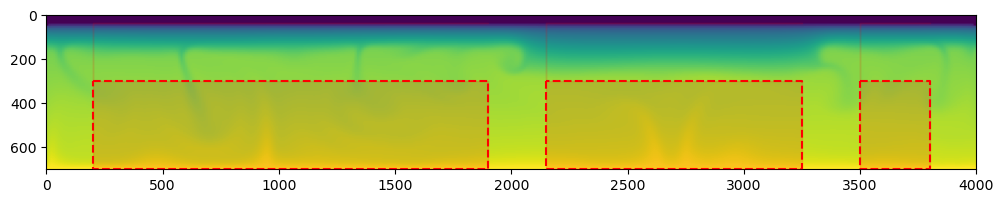

In [49]:
i= 400

datai = datasets[1].temperature[i].values.T

shift_craton = 700.0e3
xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3

xcbegin = xcenter - Lcraton/2.0e3 + 50
xcend = xcenter + Lcraton/2.0e3 - 50
zcbegin = 200.0
zcend = Lz/1.0e3

meanc = calc_mean_region(datai, xx, zz, xcbegin, xcend, zcbegin, zcend)
print(f"Mean temperature in craton: {meanc}")
# i= 400

data = datasets[0].temperature[i].values.T
region  = (xx >= (xcenter - Lcraton/2.0e3 + 50)) & (xx <= (xcenter + Lcraton/2.0e3 - 50)) & (zz >= 200.0) & (zz <= Lz)

xregion = (xx >= (xcenter - Lcraton/2.0e3 + 50)) & (xx <= (xcenter + Lcraton/2.0e3 - 50))
zregion = (zz >= 200) & (zz <= Lz)

Nx_new = len(xregion[0][xregion[0] == True])
Nz_new = len(zregion.T[0][zregion.T[0] == True])

data_region = np.asarray(datai)[region].reshape(Nz_new, Nx_new)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.imshow(datai, origin='lower', aspect='auto', extent=[0, Lx/1000, Lz/1000, 0], cmap='viridis')

# xc_points = [xcenter - Lcraton/2.0e3 + 50,
#             xcenter - Lcraton/2.0e3 + 50, 
#             xcenter + Lcraton/2.0e3 - 50,
#             xcenter + Lcraton/2.0e3 - 50,
#             xcenter - Lcraton/2.0e3 + 50]

if(mobile_belt):
    xc_points = [xcenter - 150,
                xcenter - 150, 
                xcenter + 150,
                xcenter + 150,
                xcenter - 150]

    zc_points = [300,
                Lz/1000,
                Lz/1000,
                300,
                300]

    #Out of cratonic region - left side
    xl_points = [200,
                xcenter - Lcraton/2.0e3 - 200,
                xcenter - Lcraton/2.0e3 - 200,
                200,
                200]
    zl_points = [300,
                300,
                Lz/1000,
                Lz/1000,
                300]

    xr_points = [xcenter + Lcraton/2.0e3 + 200,
                Lx/1000-200,
                Lx/1000-200,
                xcenter + Lcraton/2.0e3 + 200,
                xcenter + Lcraton/2.0e3 + 200]
    zr_points = [300,
                300,
                Lz/1000,
                Lz/1000,
                300]
else:
    xc_points = [xcenter - Lcraton/2.0e3 + 50,
                xcenter - Lcraton/2.0e3 + 50, 
                xcenter + Lcraton/2.0e3 - 50,
                xcenter + Lcraton/2.0e3 - 50,
                xcenter - Lcraton/2.0e3 + 50]

    zc_points = [300,
                Lz/1000,
                Lz/1000,
                300,
                300]

    #Out of cratonic region - left side
    xl_points = [200,
                xcenter - Lcraton/2.0e3 - 200,
                xcenter - Lcraton/2.0e3 - 200,
                200,
                200]
    zl_points = [300,
                300,
                Lz/1000,
                Lz/1000,
                300]

    xr_points = [xcenter + Lcraton/2.0e3 + 200,
                Lx/1000-200,
                Lx/1000-200,
                xcenter + Lcraton/2.0e3 + 200,
                xcenter + Lcraton/2.0e3 + 200]
    zr_points = [300,
                300,
                Lz/1000,
                Lz/1000,
                300]

ax.plot(xc_points, zc_points, '--r', zorder=51)
ax.fill_between(xc_points, zc_points, 35.5, color='red', alpha=0.15, zorder=51)

ax.plot(xl_points, zl_points, '--r', zorder=51)
ax.fill_between(xl_points, zl_points, 35.5, color='red', alpha=0.15, zorder=51)

ax.plot(xr_points, zr_points, '--r', zorder=51)
ax.fill_between(xr_points, zr_points, 35.5, color='red', alpha=0.15, zorder=51)

# ax.imshow(data_region, origin='lower', aspect='auto', extent=[xcenter - Lcraton/2.0e3 + 50, xcenter + Lcraton/2.0e3 - 50, Lz/1000, 200], cmap='inferno')

# print(np.shape(data), np.shape(xx), np.shape(zz))

In [45]:
np.mean(data_region)

1482.4436671966082

Mean temperature in craton: 1471.63


Text(0, 0.5, 'Depth [km]')

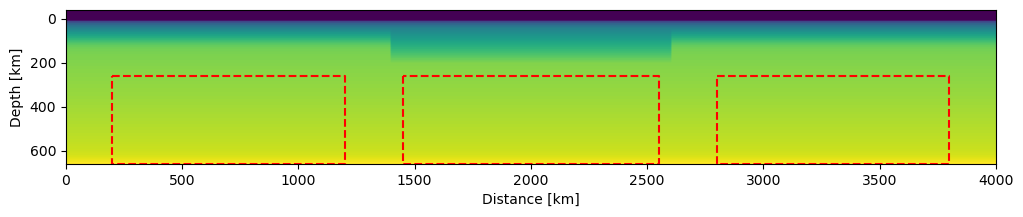

In [76]:
i= 0

datai = datasets[0].temperature[i].values.T

shift_craton = 0.0e3
xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3

xcbegin = xcenter - Lcraton/2.0e3 + 50
xcend = xcenter + Lcraton/2.0e3 - 50
zcbegin = 200.0
zcend = Lz/1.0e3

meanc = calc_mean_region(datai, xx, zz, xcbegin, xcend, zcbegin, zcend)
print(f"Mean temperature in craton: {meanc}")
# i= 400

data = datasets[0].temperature[i].values.T
region  = (xx >= (xcenter - Lcraton/2.0e3 + 50)) & (xx <= (xcenter + Lcraton/2.0e3 - 50)) & (zz >= 200.0) & (zz <= Lz)

xregion = (xx >= (xcenter - Lcraton/2.0e3 + 50)) & (xx <= (xcenter + Lcraton/2.0e3 - 50))
zregion = (zz >= 200) & (zz <= Lz)

Nx_new = len(xregion[0][xregion[0] == True])
Nz_new = len(zregion.T[0][zregion.T[0] == True])

data_region = np.asarray(datai)[region].reshape(Nz_new, Nx_new)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.imshow(datai, origin='lower', aspect='auto', extent=[0, Lx/1000, Lz/1000-40, 0-40], cmap='viridis')

if(mobile_belt):
    xc_points = np.asarray([xcenter - 150,
                xcenter - 150, 
                xcenter + 150,
                xcenter + 150,
                xcenter - 150])

    zc_points = np.asarray([300,
                Lz/1000,
                Lz/1000,
                300,
                300])

    #Out of cratonic region - left side
    xl_points = np.asarray([200,
                xcenter - Lcraton/2.0e3 - 200,
                xcenter - Lcraton/2.0e3 - 200,
                200,
                200])
    zl_points = np.asarray([300,
                300,
                Lz/1000,
                Lz/1000,
                300])

    xr_points = np.asarray([xcenter + Lcraton/2.0e3 + 200,
                Lx/1000-200,
                Lx/1000-200,
                xcenter + Lcraton/2.0e3 + 200,
                xcenter + Lcraton/2.0e3 + 200])
    zr_points = np.asarray([300,
                300,
                Lz/1000,
                Lz/1000,
                300])
else:
    xc_points = np.asarray([xcenter - Lcraton/2.0e3 + 50,
                xcenter - Lcraton/2.0e3 + 50, 
                xcenter + Lcraton/2.0e3 - 50,
                xcenter + Lcraton/2.0e3 - 50,
                xcenter - Lcraton/2.0e3 + 50])

    zc_points = np.asarray([300,
                Lz/1000,
                Lz/1000,
                300,
                300])

    #Out of cratonic region - left side
    xl_points = np.asarray([200,
                xcenter - Lcraton/2.0e3 - 200,
                xcenter - Lcraton/2.0e3 - 200,
                200,
                200])
    zl_points = np.asarray([300,
                300,
                Lz/1000,
                Lz/1000,
                300])

    xr_points = np.asarray([xcenter + Lcraton/2.0e3 + 200,
                Lx/1000-200,
                Lx/1000-200,
                xcenter + Lcraton/2.0e3 + 200,
                xcenter + Lcraton/2.0e3 + 200])
    zr_points = np.asarray([300,
                300,
                Lz/1000,
                Lz/1000,
                300])

ax.plot(xc_points, zc_points-40, '--r', zorder=51)
# ax.fill_between(xc_points, zc_points-40, 35.5, color='red', alpha=0.15, zorder=51)

ax.plot(xl_points, zl_points-40, '--r', zorder=51)
# ax.fill_between(xl_points, zl_points-40, 35.5, color='red', alpha=0.15, zorder=51)

ax.plot(xr_points, zr_points-40, '--r', zorder=51)
# ax.fill_between(xr_points, zr_points-40, 35.5, color='red', alpha=0.15, zorder=51)

shift_craton = 700.0e3
xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3

xc_points_sc = np.asarray([xcenter - Lcraton/2.0e3 + 50,
                xcenter - Lcraton/2.0e3 + 50, 
                xcenter + Lcraton/2.0e3 - 50,
                xcenter + Lcraton/2.0e3 - 50,
                xcenter - Lcraton/2.0e3 + 50])

zc_points_sc = np.asarray([300,
            Lz/1000,
            Lz/1000,
            300,
            300])

#Out of cratonic region - left side
xl_points_sc = np.asarray([200,
            xcenter - Lcraton/2.0e3 - 200,
            xcenter - Lcraton/2.0e3 - 200,
            200,
            200])
zl_points_sc = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])

xr_points_sc = np.asarray([xcenter + Lcraton/2.0e3 + 200,
            Lx/1000-200,
            Lx/1000-200,
            xcenter + Lcraton/2.0e3 + 200,
            xcenter + Lcraton/2.0e3 + 200])
zr_points_sc = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])

# ax.plot(xc_points_sc, zc_points_sc-40, '--', color='gray', zorder=51)
# ax.fill_between(xc_points, zc_points-40, 35.5, color='red', alpha=0.15, zorder=51)

# ax.plot(xl_points_sc, zl_points_sc-40, '--', color='gray', zorder=51)
# ax.fill_between(xl_points, zl_points-40, 35.5, color='red', alpha=0.15, zorder=51)

# ax.plot(xr_points_sc, zr_points_sc-40, '--', color='gray', zorder=51)
# ax.fill_between(xr_points, zr_points-40, 35.5, color='red', alpha=0.15, zorder=51)
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Depth [km]')

# ax.imshow(data_region, origin='lower', aspect='auto', extent=[xcenter - Lcraton/2.0e3 + 50, xcenter + Lcraton/2.0e3 - 50, Lz/1000, 200], cmap='inferno')

# print(np.shape(data), np.shape(xx), np.shape(zz))